In [1]:
%matplotlib inline

import random

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
random.seed(1)

In [3]:
import random

def ind_max(x):
    max_value = max(x)
    max_keys = [k for k, v in enumerate(x) if v == max_value]
    return random.choice(max_keys)


class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        if random.random() > self.epsilon:
            return ind_max(self.values) #Exploit
        else:
            return random.randrange(len(self.values)) #Explore

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return


In [4]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [5]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [18]:
def simulate_tests(means=[0.1, 0.1, 0.1, 0.1, 0.9], epsilons=[0.1, 0.2, 0.3, 0.4, 0.5], 
                   filename="ipy_standard_results.tsv",
                   num_sims= 5000, horizon=250):
    
    n_arms = len(means)
    arms = [BernoulliArm(mu) for mu in means]
    best_arm = ind_max(means)
    print("Best arm is " + str(ind_max(means)))

    f = open(filename, "w")

    for epsilon in epsilons:
        algo = EpsilonGreedy(epsilon, [], [])
        algo.initialize(n_arms)
        results = test_algorithm(algo, arms, num_sims, horizon)
        for i in range(len(results[0])):
            f.write(str(epsilon) + "\t")
            f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
    f.close()
    
    # Read this 
    df = pd.read_csv('./ipy_standard_results.tsv', sep='\t', header=None, 
                     names=["Epsilon", "Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])
    
    return df, best_arm

# Visualization

## Probability of choosing best arm over time

In [15]:
def plot_prob_best_arm(df, best_arm):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df[df['ChosenArm']==best_arm].groupby(['T', 'Epsilon'])['ChosenArm'].count().to_frame()
    xseries = xseries['ChosenArm'].apply(lambda x: x/5000).unstack().plot(ax=ax)
    xseries.set_ylabel(f"Probability of selecting best arm ({best_arm})")
    xseries.set_xlabel("Time")

## Average reward over time

In [11]:
def plot_avg_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Epsilon'])['Reward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Average reward")
    xseries.set_xlabel("Time")

## Cumulative reward over time

In [12]:
def plot_cumulative_reward(df):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(15,8))
    xseries = df.groupby(['T', 'Epsilon'])['CumulativeReward'].mean().unstack().plot(ax=ax)
    xseries.set_ylabel("Cumulative reward")
    xseries.set_xlabel("Time")

## Example

Best arm is 4


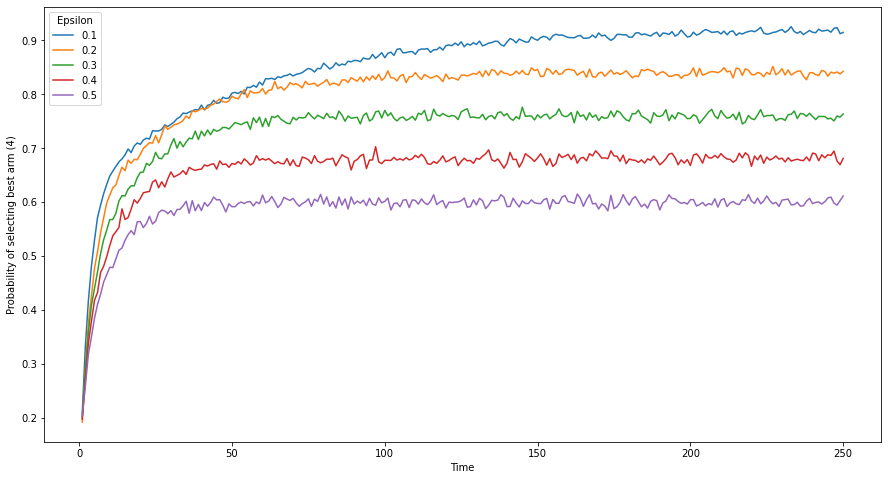

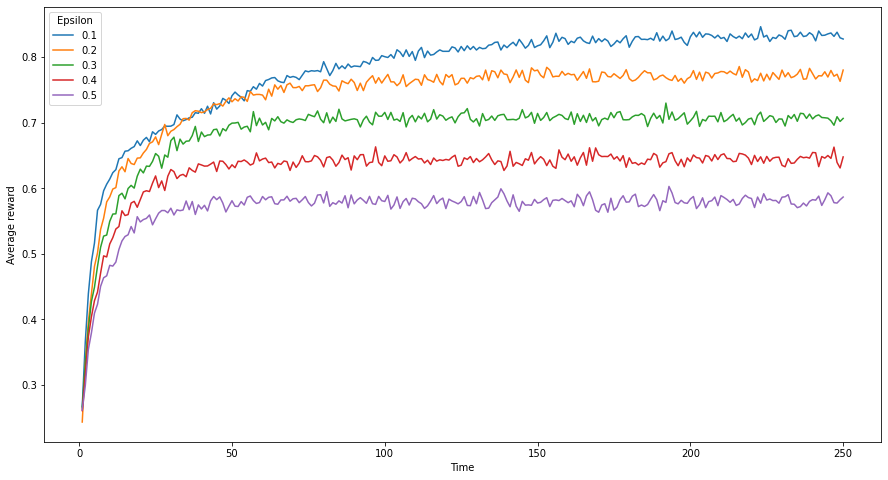

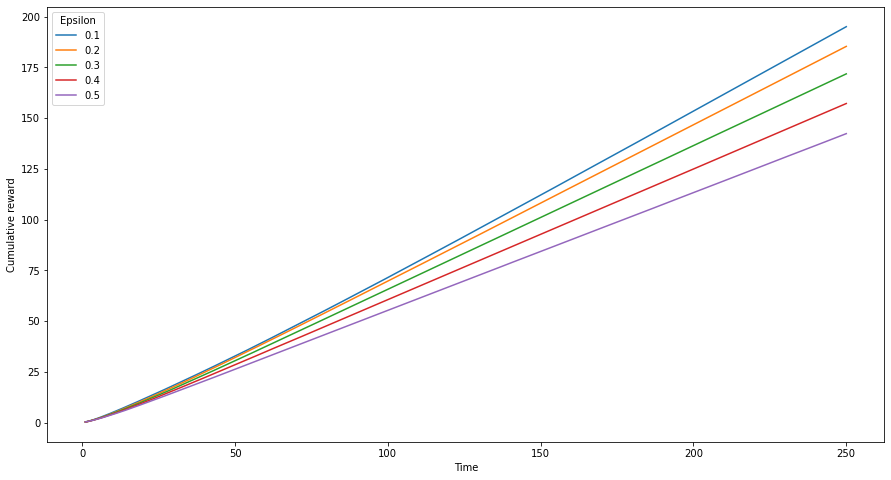

In [19]:
df, best_arm = simulate_tests()

plot_prob_best_arm(df, best_arm)
plot_avg_reward(df)
plot_cumulative_reward(df)

# Exercises

## Only 2 arms

Best arm is 1


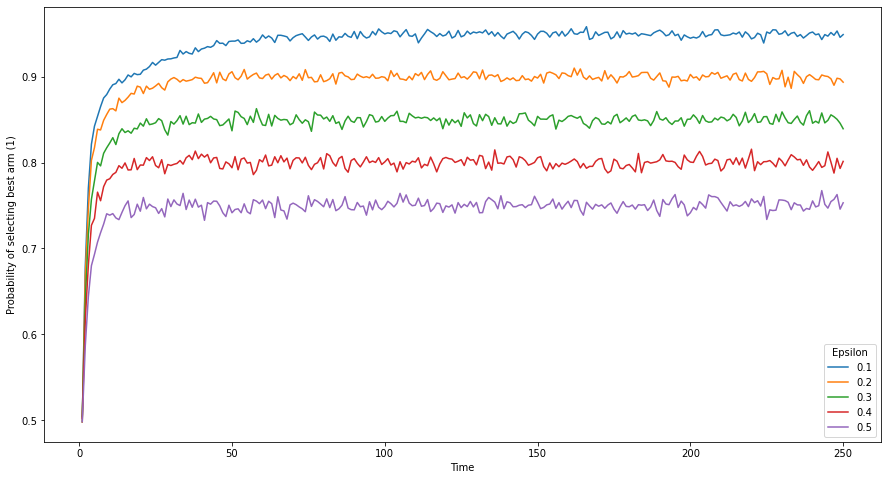

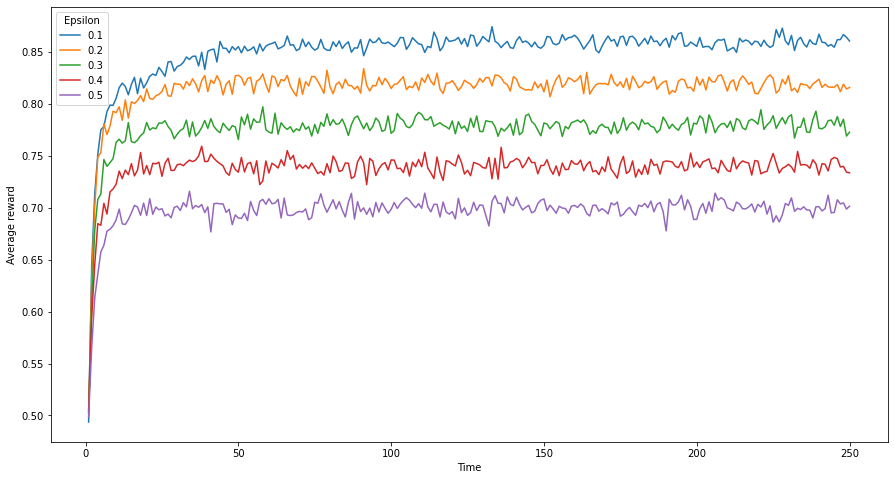

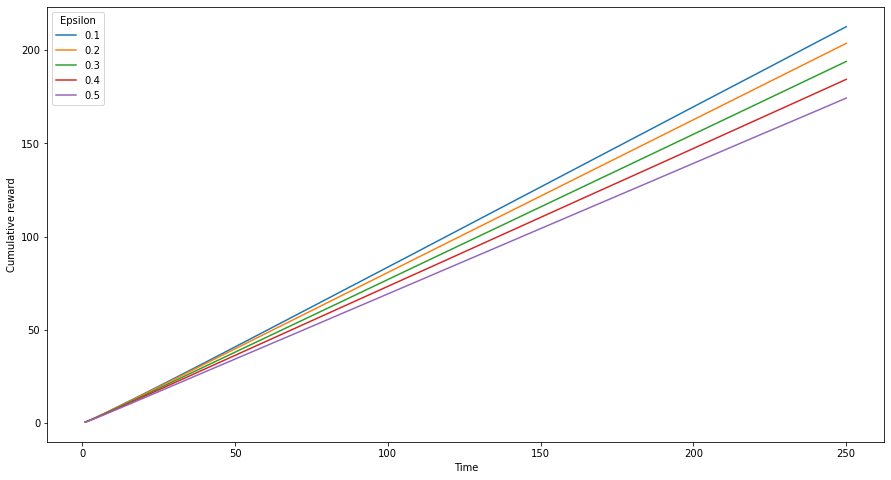

In [22]:
# With only two arms
df, best_arm = simulate_tests(means=[0.1, 0.9])

plot_prob_best_arm(df, best_arm)
plot_avg_reward(df)
plot_cumulative_reward(df)

## 200 arms

In [ ]:
means = [0.1 for x in range(199)] + [0.9]
df, best_arm = simulate_tests(means=means)

plot_prob_best_arm(df, best_arm)
plot_avg_reward(df)
plot_cumulative_reward(df)

## When all arms have probabilities close to 0

In [ ]:
means = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
df, best_arm = simulate_tests(means=means)

plot_prob_best_arm(df, best_arm)
plot_avg_reward(df)
plot_cumulative_reward(df)